In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from torchmetrics import Accuracy
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import random

In [ ]:
class DeepEmotion(nn.Module):
    def __init__(self):
        super(DeepEmotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return {
            'logits': out,
            'probs': F.softmax(out, dim=1)
        }

In [ ]:
model = DeepEmotion()
print(model)

DeepEmotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace

In [ ]:
import kagglehub
path = kagglehub.dataset_download("deadskull7/fer2013")
print("Path to dataset files:", path)

100%|██████████| 96.6M/96.6M [00:00<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deadskull7/fer2013/versions/1


In [ ]:
df = pd.read_csv(os.path.join(path,'fer2013.csv'))
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
train_data = df[df['Usage'] == 'Training']['pixels']
train_labels = df[df['Usage'] == 'Training']['emotion']
test_data = df[df['Usage'] == 'PrivateTest']['pixels']
test_labels = df[df['Usage'] == 'PrivateTest']['emotion']
val_data = df[df['Usage'] == 'PublicTest']['pixels']
val_labels = df[df['Usage'] == 'PublicTest']['emotion']

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(val_data.shape, val_labels.shape)

(28709,) (28709,)
(3589,) (3589,)
(3589,) (3589,)


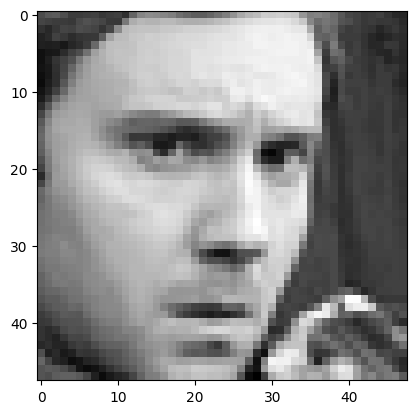

torch.Size([48, 48])


In [ ]:
x = np.fromstring(train_data[0], dtype=np.float32, sep=' ')
x = np.asarray(x)
x = x.reshape(48, 48)
plt.imshow(x, cmap='gray')
plt.show()
print(torch.from_numpy(x).shape)

In [ ]:
def transform_data_to_array(data, labels):
  x = [np.asarray(np.fromstring(pixel_sequence, dtype=np.float32, sep=' ')) for pixel_sequence in data]
  x = [k.reshape(48, 48) for k in x]
  y = np.asarray(labels)
  return x, y

train_data, train_labels = transform_data_to_array(train_data, train_labels)
test_data, test_labels = transform_data_to_array(test_data, test_labels)
val_data, val_labels = transform_data_to_array(val_data, val_labels)

<ipython-input-12-652d71c2acdb>:2: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  x = [np.asarray(np.fromstring(pixel_sequence, dtype=np.float32, sep=' ')) for pixel_sequence in data]


ValueError: cannot reshape array of size 0 into shape (48,48)

In [ ]:
class FERDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.from_numpy(targets)
    self.transform = transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    image = self.data[index]
    label = self.targets[index]
    if self.transform is not None:
      image = self.transform(image)
    return image, label

In [ ]:
transform_images = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FERDataset(train_data, train_labels, transform=transform_images)
val_dataset = FERDataset(val_data, val_labels, transform=transform_images)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

tensor(3)


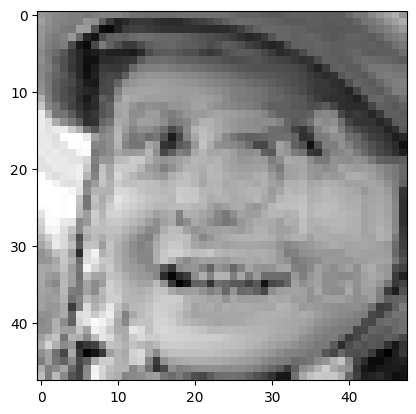

In [ ]:
imgs, labels = next(iter(train_loader))
plt.imshow(imgs[0].squeeze(), cmap='gray')
print(labels[0])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Trainer:
  def __init__(self, model, train_loader, val_loader, criterion, optimizer):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.criterion = criterion
    self.optimizer = optimizer

  def fit(self, epochs):
    self.model.train()

    acc = Accuracy(task="multiclass", num_classes=7)
    acc = acc.to(device)

    train_accs = []
    train_loss = []
    val_accs = []

    for epoch in range(epochs):
      acc.reset()
      pbar = tqdm(self.train_loader, desc='train')
      for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = self.model(imgs)
        loss = self.criterion(outputs['logits'].squeeze(), labels)
        loss.backward()
        optimizer.step()

        batch_acc = acc(outputs["probs"], labels)
        train_loss.append(loss.item())
        pbar.set_postfix({"loss": loss.item(), "acc": batch_acc.item()})

      train_epoch_acc = acc.compute().detach()
      train_accs.append(train_epoch_acc)
      print(f"Epoch {epoch} train accuracy: {train_epoch_acc.item()}")
      acc.reset()

      if self.val_loader:
        pbar = tqdm(self.val_loader, desc='val')
        for imgs, labels in pbar:
          imgs = imgs.to(device)
          labels = labels.to(device)

          outputs = self.model(imgs)
          loss = self.criterion(outputs['logits'], labels)

          batch_acc = acc(outputs["probs"], labels)
          pbar.set_postfix({"loss": loss.item(), "acc": batch_acc.item()})

        val_epoch_acc = acc.compute().detach()
        val_accs.append(val_epoch_acc)
        print(f"Epoch {epoch} val accuracy: {val_epoch_acc.item()}")
        acc.reset()

    return train_accs, train_loss, val_accs

In [ ]:
def plot_results(tloss, tacc, vacc):
  acc = Accuracy(task="multiclass", num_classes=7)
  acc = acc.to(device)

  fig, ax = acc.plot(tacc)
  if vacc:
    _, ax = acc.plot(vacc, ax)
  fig.show()

  fig = plt.figure()
  ax = fig.gca()
  ax.plot(range(len(tloss)), tloss)
  ax.set_title("Training loss")
  ax.set_xlabel("Step")
  ax.set_ylabel("Loss")
  fig.show()

train: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, loss=2.01, acc=0.148]


Epoch 0 train accuracy: 0.1484375


train: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s, loss=2.03, acc=0.109]


Epoch 1 train accuracy: 0.109375


train: 100%|██████████| 1/1 [00:00<00:00, 36.80it/s, loss=1.99, acc=0.141]


Epoch 2 train accuracy: 0.140625


train: 100%|██████████| 1/1 [00:00<00:00, 38.04it/s, loss=1.92, acc=0.141]


Epoch 3 train accuracy: 0.140625


train: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s, loss=1.91, acc=0.141]


Epoch 4 train accuracy: 0.140625


train: 100%|██████████| 1/1 [00:00<00:00, 36.10it/s, loss=1.91, acc=0.188]


Epoch 5 train accuracy: 0.1875


train: 100%|██████████| 1/1 [00:00<00:00, 30.27it/s, loss=1.9, acc=0.188]


Epoch 6 train accuracy: 0.1875


train: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s, loss=1.89, acc=0.211]


Epoch 7 train accuracy: 0.2109375


train: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s, loss=1.88, acc=0.258]


Epoch 8 train accuracy: 0.2578125


train: 100%|██████████| 1/1 [00:00<00:00, 37.16it/s, loss=1.87, acc=0.25]


Epoch 9 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s, loss=1.86, acc=0.25]


Epoch 10 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.84it/s, loss=1.85, acc=0.25]


Epoch 11 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 37.85it/s, loss=1.83, acc=0.25]


Epoch 12 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s, loss=1.82, acc=0.25]


Epoch 13 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.06it/s, loss=1.81, acc=0.25]


Epoch 14 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.25it/s, loss=1.8, acc=0.25]


Epoch 15 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.72it/s, loss=1.8, acc=0.25]


Epoch 16 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s, loss=1.79, acc=0.25]


Epoch 17 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.50it/s, loss=1.79, acc=0.25]


Epoch 18 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.52it/s, loss=1.79, acc=0.25]


Epoch 19 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, loss=1.79, acc=0.25]


Epoch 20 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.72it/s, loss=1.78, acc=0.25]


Epoch 21 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 35.59it/s, loss=1.78, acc=0.25]


Epoch 22 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s, loss=1.77, acc=0.25]


Epoch 23 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s, loss=1.77, acc=0.25]


Epoch 24 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s, loss=1.77, acc=0.25]


Epoch 25 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s, loss=1.77, acc=0.25]

Epoch 26 train accuracy: 0.25

train: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s, loss=1.77, acc=0.25]


Epoch 27 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.61it/s, loss=1.77, acc=0.25]


Epoch 28 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s, loss=1.76, acc=0.25]


Epoch 29 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.18it/s, loss=1.77, acc=0.25]


Epoch 30 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.70it/s, loss=1.77, acc=0.25]


Epoch 31 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.55it/s, loss=1.76, acc=0.25]


Epoch 32 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s, loss=1.77, acc=0.25]


Epoch 33 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.90it/s, loss=1.76, acc=0.25]


Epoch 34 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.99it/s, loss=1.77, acc=0.25]


Epoch 35 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.76it/s, loss=1.77, acc=0.25]


Epoch 36 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.94it/s, loss=1.76, acc=0.25]


Epoch 37 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s, loss=1.76, acc=0.25]


Epoch 38 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.59it/s, loss=1.76, acc=0.25]


Epoch 39 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s, loss=1.76, acc=0.25]


Epoch 40 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s, loss=1.76, acc=0.25]


Epoch 41 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.25it/s, loss=1.76, acc=0.25]


Epoch 42 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s, loss=1.76, acc=0.25]


Epoch 43 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.78it/s, loss=1.76, acc=0.25]


Epoch 44 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.41it/s, loss=1.76, acc=0.25]


Epoch 45 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, loss=1.77, acc=0.25]


Epoch 46 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s, loss=1.76, acc=0.25]


Epoch 47 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.95it/s, loss=1.76, acc=0.25]


Epoch 48 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s, loss=1.76, acc=0.25]


Epoch 49 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s, loss=1.76, acc=0.25]


Epoch 50 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.20it/s, loss=1.76, acc=0.25]


Epoch 51 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s, loss=1.76, acc=0.25]


Epoch 52 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, loss=1.76, acc=0.25]


Epoch 53 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.56it/s, loss=1.75, acc=0.25]


Epoch 54 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.14it/s, loss=1.77, acc=0.25]


Epoch 55 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s, loss=1.76, acc=0.25]


Epoch 56 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s, loss=1.76, acc=0.25]


Epoch 57 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s, loss=1.76, acc=0.25]


Epoch 58 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 37.45it/s, loss=1.76, acc=0.25]


Epoch 59 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s, loss=1.76, acc=0.25]


Epoch 60 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.66it/s, loss=1.76, acc=0.25]


Epoch 61 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.07it/s, loss=1.76, acc=0.25]


Epoch 62 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s, loss=1.76, acc=0.25]


Epoch 63 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.62it/s, loss=1.76, acc=0.25]


Epoch 64 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.63it/s, loss=1.76, acc=0.25]


Epoch 65 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.91it/s, loss=1.77, acc=0.25]


Epoch 66 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s, loss=1.76, acc=0.25]


Epoch 67 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.87it/s, loss=1.76, acc=0.25]


Epoch 68 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s, loss=1.76, acc=0.25]


Epoch 69 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.83it/s, loss=1.76, acc=0.25]


Epoch 70 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.05it/s, loss=1.76, acc=0.25]


Epoch 71 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s, loss=1.76, acc=0.25]


Epoch 72 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s, loss=1.76, acc=0.25]


Epoch 73 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.77it/s, loss=1.76, acc=0.25]


Epoch 74 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.91it/s, loss=1.76, acc=0.25]


Epoch 75 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s, loss=1.76, acc=0.25]


Epoch 76 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.25it/s, loss=1.77, acc=0.25]


Epoch 77 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s, loss=1.76, acc=0.25]


Epoch 78 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s, loss=1.76, acc=0.25]


Epoch 79 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s, loss=1.76, acc=0.25]


Epoch 80 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s, loss=1.76, acc=0.25]


Epoch 81 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s, loss=1.76, acc=0.25]


Epoch 82 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.68it/s, loss=1.76, acc=0.25]


Epoch 83 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s, loss=1.76, acc=0.25]


Epoch 84 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s, loss=1.76, acc=0.25]


Epoch 85 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.11it/s, loss=1.76, acc=0.25]


Epoch 86 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s, loss=1.76, acc=0.25]


Epoch 87 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s, loss=1.76, acc=0.25]


Epoch 88 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s, loss=1.76, acc=0.25]


Epoch 89 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s, loss=1.76, acc=0.25]


Epoch 90 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s, loss=1.76, acc=0.25]


Epoch 91 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.31it/s, loss=1.77, acc=0.25]


Epoch 92 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s, loss=1.76, acc=0.25]


Epoch 93 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s, loss=1.76, acc=0.25]


Epoch 94 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s, loss=1.76, acc=0.25]


Epoch 95 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s, loss=1.76, acc=0.25]


Epoch 96 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s, loss=1.76, acc=0.25]


Epoch 97 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.27it/s, loss=1.77, acc=0.25]


Epoch 98 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s, loss=1.76, acc=0.25]


Epoch 99 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s, loss=1.76, acc=0.25]


Epoch 100 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.04it/s, loss=1.76, acc=0.25]


Epoch 101 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.54it/s, loss=1.75, acc=0.25]


Epoch 102 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.74it/s, loss=1.76, acc=0.25]


Epoch 103 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.89it/s, loss=1.76, acc=0.25]


Epoch 104 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.57it/s, loss=1.76, acc=0.25]


Epoch 105 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s, loss=1.76, acc=0.25]


Epoch 106 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s, loss=1.76, acc=0.25]


Epoch 107 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s, loss=1.77, acc=0.25]


Epoch 108 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.63it/s, loss=1.76, acc=0.25]


Epoch 109 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s, loss=1.76, acc=0.25]


Epoch 110 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s, loss=1.76, acc=0.25]


Epoch 111 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.44it/s, loss=1.77, acc=0.25]


Epoch 112 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s, loss=1.76, acc=0.25]


Epoch 113 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.10it/s, loss=1.77, acc=0.25]


Epoch 114 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 34.19it/s, loss=1.76, acc=0.25]


Epoch 115 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s, loss=1.76, acc=0.25]


Epoch 116 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.47it/s, loss=1.76, acc=0.25]


Epoch 117 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 33.51it/s, loss=1.76, acc=0.25]


Epoch 118 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 32.88it/s, loss=1.76, acc=0.25]


Epoch 119 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, loss=1.77, acc=0.25]


Epoch 120 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.13it/s, loss=1.76, acc=0.25]


Epoch 121 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s, loss=1.76, acc=0.25]


Epoch 122 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.91it/s, loss=1.76, acc=0.25]


Epoch 123 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s, loss=1.76, acc=0.25]


Epoch 124 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s, loss=1.76, acc=0.25]


Epoch 125 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s, loss=1.76, acc=0.25]


Epoch 126 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s, loss=1.76, acc=0.25]


Epoch 127 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, loss=1.76, acc=0.25]


Epoch 128 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s, loss=1.76, acc=0.25]


Epoch 129 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.86it/s, loss=1.77, acc=0.25]


Epoch 130 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.73it/s, loss=1.76, acc=0.25]


Epoch 131 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.01it/s, loss=1.76, acc=0.25]


Epoch 132 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s, loss=1.76, acc=0.25]


Epoch 133 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s, loss=1.76, acc=0.25]


Epoch 134 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s, loss=1.76, acc=0.25]


Epoch 135 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s, loss=1.77, acc=0.25]


Epoch 136 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.49it/s, loss=1.77, acc=0.25]


Epoch 137 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.79it/s, loss=1.76, acc=0.25]


Epoch 138 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, loss=1.76, acc=0.25]


Epoch 139 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s, loss=1.76, acc=0.25]


Epoch 140 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s, loss=1.76, acc=0.25]


Epoch 141 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s, loss=1.76, acc=0.25]


Epoch 142 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s, loss=1.76, acc=0.25]


Epoch 143 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s, loss=1.76, acc=0.25]


Epoch 144 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s, loss=1.77, acc=0.25]


Epoch 145 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s, loss=1.76, acc=0.25]


Epoch 146 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s, loss=1.77, acc=0.25]


Epoch 147 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s, loss=1.76, acc=0.25]


Epoch 148 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, loss=1.76, acc=0.25]


Epoch 149 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s, loss=1.77, acc=0.25]


Epoch 150 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s, loss=1.76, acc=0.25]


Epoch 151 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.71it/s, loss=1.76, acc=0.25]


Epoch 152 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s, loss=1.76, acc=0.25]


Epoch 153 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s, loss=1.76, acc=0.25]


Epoch 154 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s, loss=1.76, acc=0.25]


Epoch 155 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s, loss=1.76, acc=0.25]


Epoch 156 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s, loss=1.76, acc=0.25]


Epoch 157 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.53it/s, loss=1.77, acc=0.25]


Epoch 158 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s, loss=1.76, acc=0.25]


Epoch 159 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.44it/s, loss=1.76, acc=0.25]


Epoch 160 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s, loss=1.77, acc=0.25]


Epoch 161 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, loss=1.76, acc=0.25]


Epoch 162 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s, loss=1.77, acc=0.25]


Epoch 163 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s, loss=1.76, acc=0.25]


Epoch 164 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s, loss=1.76, acc=0.25]


Epoch 165 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s, loss=1.76, acc=0.25]


Epoch 166 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s, loss=1.76, acc=0.25]


Epoch 167 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s, loss=1.76, acc=0.25]


Epoch 168 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s, loss=1.76, acc=0.25]


Epoch 169 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.20it/s, loss=1.76, acc=0.25]


Epoch 170 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s, loss=1.76, acc=0.25]


Epoch 171 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 25.51it/s, loss=1.76, acc=0.25]


Epoch 172 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s, loss=1.76, acc=0.25]


Epoch 173 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s, loss=1.76, acc=0.25]


Epoch 174 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, loss=1.77, acc=0.25]


Epoch 175 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s, loss=1.77, acc=0.25]


Epoch 176 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s, loss=1.76, acc=0.25]


Epoch 177 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s, loss=1.76, acc=0.25]


Epoch 178 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 27.31it/s, loss=1.76, acc=0.25]


Epoch 179 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s, loss=1.76, acc=0.25]


Epoch 180 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 24.96it/s, loss=1.76, acc=0.25]


Epoch 181 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s, loss=1.76, acc=0.25]


Epoch 182 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.91it/s, loss=1.76, acc=0.25]


Epoch 183 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s, loss=1.76, acc=0.25]


Epoch 184 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s, loss=1.76, acc=0.25]


Epoch 185 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s, loss=1.77, acc=0.25]


Epoch 186 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s, loss=1.76, acc=0.25]


Epoch 187 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s, loss=1.76, acc=0.25]


Epoch 188 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s, loss=1.77, acc=0.25]


Epoch 189 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s, loss=1.76, acc=0.25]


Epoch 190 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s, loss=1.76, acc=0.25]


Epoch 191 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.38it/s, loss=1.76, acc=0.25]


Epoch 192 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 26.34it/s, loss=1.77, acc=0.25]


Epoch 193 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s, loss=1.77, acc=0.25]


Epoch 194 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.78it/s, loss=1.76, acc=0.25]


Epoch 195 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s, loss=1.76, acc=0.25]


Epoch 196 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s, loss=1.76, acc=0.25]


Epoch 197 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s, loss=1.76, acc=0.25]


Epoch 198 train accuracy: 0.25


train: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s, loss=1.77, acc=0.25]


Epoch 199 train accuracy: 0.25


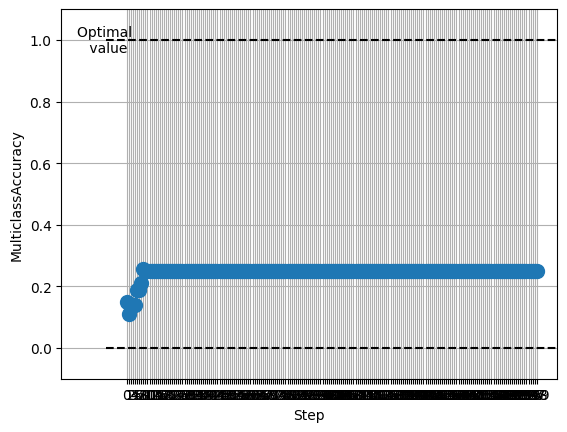

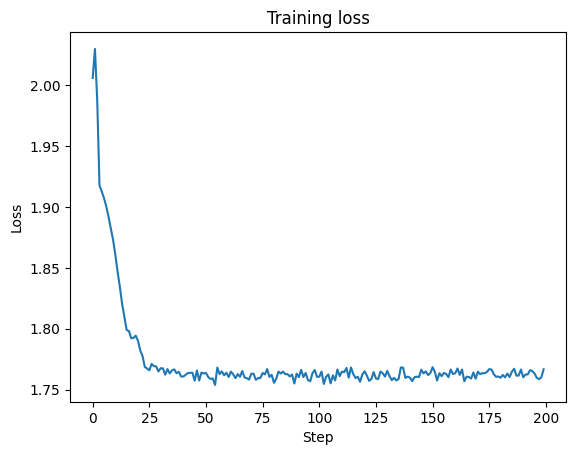

In [ ]:
overfit_set = torch.utils.data.Subset(train_dataset, random.choices(range(len(train_dataset)), k=128))
overfit_loader = DataLoader(overfit_set, batch_size=128, shuffle=True)

model = DeepEmotion()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
trainer = Trainer(model, overfit_loader, None, criterion, optimizer)
train_accs, train_loss, _ = trainer.fit(200)
plot_results(train_loss, train_accs, [])

In [ ]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]             400
         MaxPool2d-2            [-1, 8, 21, 21]               0
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 10, 17, 17]           2,010
         MaxPool2d-5             [-1, 10, 8, 8]               0
              ReLU-6             [-1, 10, 8, 8]               0
            Linear-7                   [-1, 32]          20,512
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 46, 46]             100
           Conv2d-11           [-1, 10, 44, 44]             910
        MaxPool2d-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             910
           Conv2d-14           [-1, 10,